In [57]:
import numpy as np
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer , TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score




In [2]:
df_train = pd.read_csv('data/train_kaggle.csv', sep=',', encoding='utf-8')


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [4]:
df_train['text'].apply(type).unique()
# explore more why the text type is coming as float

array([<class 'str'>, <class 'float'>], dtype=object)

In [5]:
X = df_train['text'].drop(df_train[df_train['text'].apply(type) == float].index)

In [6]:
X.apply(type).unique()

array([<class 'str'>], dtype=object)

In [7]:
treebank_word_tokenize = TreebankWordTokenizer().tokenize
tokens = [treebank_word_tokenize(content.lower()) for content in X]

In [8]:
nltk.download('stopwords') # figure out a way to not download it every time?
stop_word = set(stopwords.words('english')) #only unique stop words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
documents = [[word for word in words if word not in stop_word]
        for words in tokens]

In [32]:
# use porter stemmer or wordnet lemmatizer to see which one is suiting your use case
#porter = PorterStemmer()
# docs_porter = [[porter.stem(word) for word in words]
#                for words in docs]
# from nltk.stem import WordNetLemmatizer
# wordnet = WordNetLemmatizer()
# documents_wordnet = [[wordnet.lemmatize(word) for word in words]
#                 for words in documents]

In [10]:
#change above X if we r using tokenize and other nlp process
#Dropping the Nan values and info
df_train.dropna(inplace=True)
X = df_train['text']
y = df_train['label']

# do the similar think on headline (author ?? or source)
# name these to test , validation
X_train,  X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [11]:
tfidf_vectorizer  = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 2)

In [12]:
tfidf_vectorizer.fit(X)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_validation_tfidf = tfidf_vectorizer.transform(X_test)

## Modeling

### Logistic Regression

In [13]:
lr = LogisticRegression()
# train our model
lr.fit(X_train_tfidf, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
y_validation_predict = lr.predict(X_validation_tfidf)
#y_validation_predict[:10]


In [23]:
lr_acc = accuracy_score(y_test, y_validation_predict) *  100 
lr_F1 = f1_score(y_test, y_validation_predict) * 100
lr_precision = precision_score(y_test, y_validation_predict) * 100
lr_recall = recall_score(y_test, y_validation_predict) * 100
print ("Logistic regression accuracy and F1 score \n")
print ("Accuracy {:.5}".format(lr_acc))
print ("F1 {:.5}".format(lr_F1))
print ("Precision {:.5}".format(lr_precision))
print ("Recall {:.5}".format(lr_recall))

Logistic regression accuracy and F1 score 

Accuracy 95.215
F1 94.342
Precision 95.049
Recall 93.646


### Code to plot confusion matrix


In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_confusion_matrix(model, y_pred, y_true):
    '''Code stolen brazenly from sklearn example.'''
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);


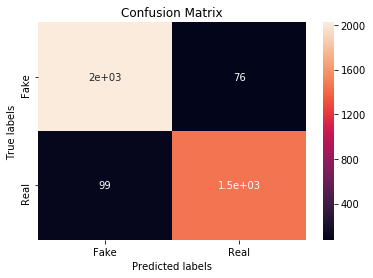

In [50]:
plot_confusion_matrix(lr, y_validation_predict, y_test)

### Code to plot ROC 

In [54]:
def plot_roc(probs, y_true, title, xlabel, ylabel):
    # ROC
    tpr, fpr, thresholds = roc_curve(v_probs, y_test)

    plt.hold(True)
    plt.plot(fpr, tpr)

    # 45 degree line
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx, color='red')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()
    
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)
    
    return tprs, fprs, thresholds.tolist()


In [52]:
v_probs = lr.predict_proba(X_validation_tfidf)[:, 1]



/Users/ashish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/ashish/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/ashish/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


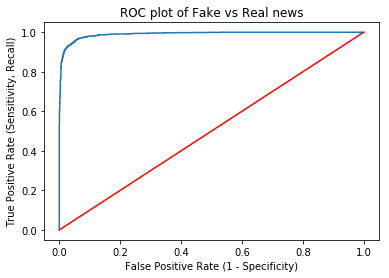

In [59]:
plot_roc(v_probs, y_test, "ROC plot of Fake vs Real news", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)");


In [61]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test, y_validation_predict)

0.9501246390939875

#### Lets see if random forest is giving us any improvements

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(n_estimators=100,n_jobs=3)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
rf.predict(X_validation_tfidf)
y_validation_predict = lr.predict(X_validation_tfidf)

In [69]:
rf_acc = accuracy_score(y_test, y_validation_predict) *  100 
rf_F1 = f1_score(y_test, y_validation_predict) * 100
rf_precision = precision_score(y_test, y_validation_predict) * 100
rf_recall = recall_score(y_test, y_validation_predict) * 100
print ("Logistic regression accuracy and F1 score \n")
print ("Accuracy {:.5}".format(rf_acc))
print ("F1 {:.5}".format(rf_F1))
print ("Precision {:.5}".format(rf_precision))
print ("Recall {:.5}".format(rf_recall))

Logistic regression accuracy and F1 score 

Accuracy 95.215
F1 94.342
Precision 95.049
Recall 93.646


In [70]:
skm.roc_auc_score(y_test, y_validation_predict)

0.9501246390939875

# Random Forest confusion matrix

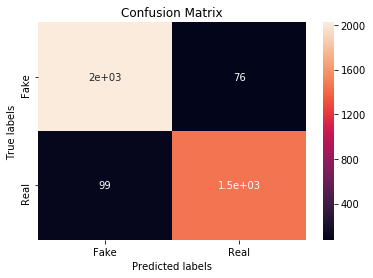

In [71]:
plot_confusion_matrix(rf, y_validation_predict, y_test)

## Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB

In [73]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb.predict(X_validation_tfidf)

In [74]:
nb_acc = accuracy_score(y_test, y_validation_predict) *  100 
nb_F1 = f1_score(y_test, y_validation_predict) * 100
nb_precision = precision_score(y_test, y_validation_predict) * 100
nb_recall = recall_score(y_test, y_validation_predict) * 100
print ("Logistic regression accuracy and F1 score \n")
print ("Accuracy {:.5}".format(nb_acc))
print ("F1 {:.5}".format(nb_F1))
print ("Precision {:.5}".format(nb_precision))
print ("Recall {:.5}".format(nb_recall))

Logistic regression accuracy and F1 score 

Accuracy 95.215
F1 94.342
Precision 95.049
Recall 93.646


#### Once we had base model for various classfifier lets do grid search to find best parameters